# Research Assistant - Language Anxiety - 6 - Deep Learning & Word2Vec

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, SpatialDropout1D

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Setting Random Seed

In [ ]:
# Set random seed for reproducibility
seed = 2019
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

## Reading The Dataset

In [ ]:
df = pd.read_excel('/content/Clean_Merged_Anxiety_Dataset_Updated AI Label.xlsx')
# df = df[df['is_ai_generated_label'] == 0]
# df = df[["Post", "LA Class"]]

# # Pisahkan kelas anxiety
# df_anxiety = df[df["LA Class"] == "Anxiety"]
# df_no_anxiety = df[df["LA Class"] == "No Anxiety"]

# # Sampling data anxiety supaya jadi sekitar 60 baris
# df_anxiety_sampled = df_anxiety.sample(n=50, random_state=42)  # Random sampling 60 baris

# # Gabungkan kembali data yang sudah disampling
# df = pd.concat([df_anxiety_sampled, df_no_anxiety], ignore_index=True)

df.head()

,Post,LA Class,is_ai_generated,is_ai_generated_label
0,"Currently, social networking, especially in th...",Anxiety,0.83,1
1,The innovation of technology has transformed a...,Anxiety,0.65,0
2,Adventure is a window to explore the world and...,Anxiety,0.91,1
3,Lack of sexual education in children in Indone...,No Anxiety,0.69,0
4,Imagine no longer needing to be stuck in traff...,Anxiety,0.52,0


In [ ]:
df['LA Class'].value_counts()

,count
LA Class,
Anxiety,268
No Anxiety,91


## Encoding The Target Variable

In [ ]:
# Menggunakan mapping manual dengan map
df['la_class'] = df['LA Class'].map({'Anxiety': 0, 'No Anxiety': 1})

# Menampilkan hasil
print("Mapping kelas ke nilai encoded:")
print(df[['LA Class', 'la_class']])

# Menghapus kolom asli
df.drop(columns=['LA Class'], inplace=True)

Mapping kelas ke nilai encoded:
       LA Class  la_class
0       Anxiety         0
1       Anxiety         0
2       Anxiety         0
3    No Anxiety         1
4       Anxiety         0
..          ...       ...
354     Anxiety         0
355     Anxiety         0
356     Anxiety         0
357     Anxiety         0
358     Anxiety         0

[359 rows x 2 columns]


## Text Preprocessing & Cleaning

### Contraction Mapping

In [ ]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

df['Post'] = df['Post'].apply(lambda x: expand_contractions(x, contraction_mapping))

### Cleaning The Text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(all_stopwords)]
    return ' '.join(words)

df['Post'] = df['Post'].apply(preprocess_text)
df['text_length'] = df['Post'].apply(len)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sdasdasd

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# Tokenisasi setiap teks
df['tokens'] = df['Post'].apply(word_tokenize)

# Menghitung jumlah kata unik dalam dfset
all_words = [word.lower() for tokens in df['tokens'] for word in tokens]
unique_word_count = len(set(all_words))

print(f"Jumlah kata unik dalam dfset: {unique_word_count}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Jumlah kata unik dalam dfset: 6642


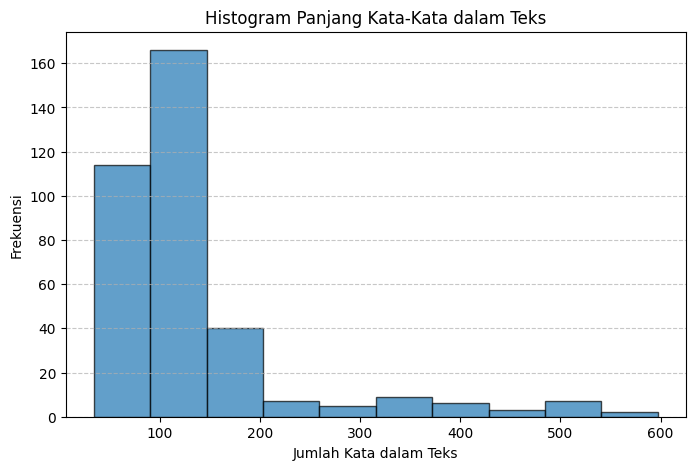

In [ ]:
# Menghitung panjang kata dalam setiap teks
df['text_length'] = df['tokens'].apply(len)

# Plot histogram panjang kata-kata dalam teks
plt.figure(figsize=(8, 5))
plt.hist(df['text_length'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel("Jumlah Kata dalam Teks")
plt.ylabel("Frekuensi")
plt.title("Histogram Panjang Kata-Kata dalam Teks")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
max_len = df['text_length'].max()
max_len

597

## Load Pre-trained Word2Vec

In [ ]:
# import gensim.downloader as api

# # Load pretrained Word2Vec model (Google News 300)
# wv = api.load('word2vec-google-news-300')

# # Fungsi untuk mendapatkan vektor kata dari Word2Vec
# def get_word_vector(word):
#     try:
#         return wv[word]
#     except KeyError:
#         return np.zeros(300)

## Load Glove

In [ ]:
# Fungsi untuk memuat GloVe ke dalam dictionary
def load_glove_embeddings(glove_file, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

## Splitting The Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['la_class'], test_size=0.3, stratify=df['la_class'], random_state=42)

## Hyperparameter

In [ ]:
max_len = max_len = df['text_length'].max()
vocab_size = 1000
embedding_dim = 300
drop_value = 0.6

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.0005, cooldown=2, verbose=1)
my_optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-4)

## Tokenizing

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding='pre', truncating='post')
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding='pre', truncating='post')

## Create Embedding Matrix For Word2Vec

In [ ]:
# word_index = tokenizer.word_index
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for word, i in word_index.items():
#     if i < vocab_size:
#         embedding_matrix[i] = get_word_vector(word)

## Create Embedding Matrix For Glove

In [ ]:
glove_file = '/content/drive/MyDrive/NLP Model/glove.6B.300d.txt'
embedding_dim = 300
embeddings_index = load_glove_embeddings(glove_file, embedding_dim)

# Membuat embedding matrix untuk GloVe
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Getting Class Weights

In [ ]:
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = dict(enumerate(class_weights))
# class_weight_dict

## Focal Loss

In [ ]:
def focal_loss(gamma=5, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.keras.backend.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.keras.backend.sum(alpha * tf.keras.backend.pow(1. - pt, gamma) * tf.keras.backend.log(pt))

    return focal_loss_fixed

## LSTM Model Architecture

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, SpatialDropout1D, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define LSTM Model
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=True))
model1.add(SpatialDropout1D(0.2))
model1.add(LSTM(32, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='tanh'))

model1.compile(loss=focal_loss(), optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5), metrics=['accuracy'])
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │         300,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 300,000 (1.14 MB)

 Trainable params: 300,000 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

## GRU Model Architecture

In [ ]:
# GRU Model
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_len, trainable=False))
model2.add(SpatialDropout1D(0.4))
model2.add(GRU(128, return_sequences = False))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation = 'tanh'))

model2.compile(loss=focal_loss(), optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-4), metrics=['accuracy'])
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │         300,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 300,000 (1.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 300,000 (1.14 MB)

## Model Training

### LSTM

#### Training LSTM

In [ ]:
# # Train LSTM
# history1 = model1.fit(training_padded, y_train, epochs=100, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop,lr_scheduler], batch_size=64)

#### LSTM Model Performances

In [ ]:
# # Melakukan prediksi
# y_pred_prob = model1.predict(testing_padded)
# y_pred_binary = (y_pred_prob > 0.5).astype(int)

# # Menampilkan classification report
# print(classification_report(y_test, y_pred_binary))

# print()

# # Menghitung metrik lainnya
# accuracy = accuracy_score(y_test, y_pred_binary)
# precision = precision_score(y_test, y_pred_binary)
# recall = recall_score(y_test, y_pred_binary)
# f1 = f1_score(y_test, y_pred_binary)
# f1_macro = f1_score(y_test, y_pred_binary, average='macro')
# f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# # Menampilkan metrik secara terpisah
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1 Score: {f1:.2f}')
# print(f'F1 Score (macro): {f1_macro:.2f}')
# print(f'F1 Score (weighted): {f1_weighted:.2f}')

#### LSTM Result Visualization

In [ ]:
# plt.plot(history1.history['loss'])
# plt.plot(history1.history['val_loss'])
# plt.title('LSTM Model: Training and Validation Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

### GRU

#### Training GRU

In [ ]:
# Train GRU
history2 = model2.fit(training_padded, y_train, epochs=75, validation_data=(testing_padded, y_test), verbose=1, callbacks=[early_stop,lr_scheduler])

Epoch 1/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7549 - loss: 40.0690 - val_accuracy: 0.4907 - val_loss: 5.8985 - learning_rate: 5.0000e-04
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5460 - loss: 7.0715 - val_accuracy: 0.3426 - val_loss: 4.4602 - learning_rate: 5.0000e-04
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4540 - loss: 13.5907 - val_accuracy: 0.3704 - val_loss: 3.9835 - learning_rate: 5.0000e-04
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4650 - loss: 5.3624 - val_accuracy: 0.3981 - val_loss: 2.4228 - learning_rate: 5.0000e-04
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5362 - loss: 9.6668 - val_accuracy: 0.4815 - val_loss: 1.9876 - learning_rate: 5.0000e-04
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5773 - loss: 6.1661 - val_accuracy: 0.5000 - val_loss: 1.9353 - learning_rate: 5.0000e-04
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5756 - loss: 3.3812 - va

#### GRU Model Performances

In [ ]:
# Melakukan prediksi
y_pred_prob = model2.predict(testing_padded)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Menampilkan classification report
print(classification_report(y_test, y_pred_binary))

print()

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step
              precision    recall  f1-score   support

           0       0.76      0.62      0.68        81
           1       0.26      0.41      0.32        27

    accuracy                           0.56       108
   macro avg       0.51      0.51      0.50       108
weighted avg       0.63      0.56      0.59       108


Accuracy: 0.56
Precision: 0.26
Recall: 0.41
F1 Score: 0.32
F1 Score (macro): 0.50
F1 Score (weighted): 0.59


#### GRU Result Visualization

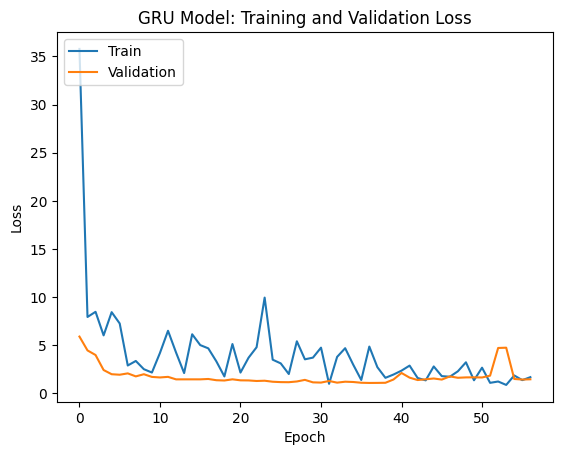

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('GRU Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Soft Voting

In [ ]:
# Soft Voting
y_pred_prob_lstm = model1.predict(testing_padded)
y_pred_prob_gru = model2.predict(testing_padded)

y_pred_prob = (y_pred_prob_lstm + y_pred_prob_gru) / 2
y_pred_binary = (y_pred_prob > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step


## Model Performances Report

In [ ]:
print(classification_report(y_test, y_pred_binary))

print()

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

              precision    recall  f1-score   support

           0       0.74      0.96      0.84        81
           1       0.00      0.00      0.00        27

    accuracy                           0.72       108
   macro avg       0.37      0.48      0.42       108
weighted avg       0.56      0.72      0.63       108


Accuracy: 0.72
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
F1 Score (macro): 0.42
F1 Score (weighted): 0.63
